# Multi-modal deep learning on basketball data


### Explore Datasets

We will use a dataset of scores from US College Basketball tournament games. Dataset has the the seed difference that represents the ranking of how strong the teams are and the score difference of the game (e.g. if team_1 wins by 5 points, the score difference is 5).


In [1]:
import pandas as pd
games_tourney = pd.read_csv("dataset/games_tourney.csv")
print(games_tourney.shape)
games_tourney.head()

(4234, 9)


,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [2]:
games_season = pd.read_csv("dataset/games_season.csv")
print(games_season.shape)
games_season.head()

(312178, 8)


,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


Among these two datasets, `games_season` dataset has the most number of data. We can use this dataset to train a deep learning model and then use that model to see how the model performs in `games_tourney` being the test dataset

### Creating a very simple model


There is an issue with one dataset and that is `seed_diff` feature is not available in `games_season` whereas it is available in `games_tourney`. This is an important feature that represents team strength. In order to get this feature available for `games_season`, we can create a simple regression model using deep learning. This model will be trained with `games_tourney` dataset and then used to produce the missing feature in `games_season` dataset.

In [3]:
# Load layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Input layer
input_tensor = Input(shape=(1,))

# Dense layer
output_layer = Dense(1)

# Connect the dense layer to the input_tensor
output_tensor = output_layer(input_tensor)

# Build the model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')


Let us create a helper function to visualize the model structure and then use it to see the layers in the deep learning model

In [4]:
# Import the plotting function
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

def model_summary(model, model_name):
    # Summarize the model
    model.summary()

    # Plot the model
    plot_model(model, to_file=model_name)

    # Display the image
    data = plt.imread(model_name)
    plt.imshow(data)
    plt.show()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


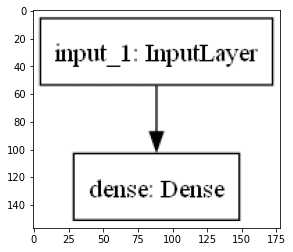

In [5]:
model_summary(model=model, model_name="seed_diff_model.png")



Let us train the model and also evaluate the performance

In [6]:
# Now fit the model
y = games_tourney['seed_diff']
X = games_tourney['score_diff']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=42, test_size=0.2, shuffle=True)
model.fit(X_train, y_train, epochs=25, batch_size=128, validation_split=0.1)

# Evaluate the model on the test data
print(model.evaluate(X_test, y_test))



Epoch 1/25
24/24 [==============================] - 0s 6ms/step - loss: 13.2669 - val_loss: 12.3314
Epoch 2/25
24/24 [==============================] - 0s 1ms/step - loss: 13.0072 - val_loss: 12.0949
Epoch 3/25
24/24 [==============================] - 0s 1ms/step - loss: 12.7491 - val_loss: 11.8587
Epoch 4/25
24/24 [==============================] - 0s 1ms/step - loss: 12.4902 - val_loss: 11.6259
Epoch 5/25
24/24 [==============================] - 0s 1ms/step - loss: 12.2329 - val_loss: 11.3940
Epoch 6/25
24/24 [==============================] - 0s 1ms/step - loss: 11.9792 - val_loss: 11.1642
Epoch 7/25
24/24 [==============================] - 0s 1ms/step - loss: 11.7272 - val_loss: 10.9390
Epoch 8/25
24/24 [==============================] - 0s 1ms/step - loss: 11.4781 - val_loss: 10.7139
Epoch 9/25
24/24 [==============================] - 0s 2ms/step - loss: 11.2293 - val_loss: 10.4894
Epoch 10/25
24/24 [==============================] - 0s 1ms/step - loss: 10.9814 - val_loss: 10.2667

Now we will create the desired `seed_diff` feature for the `games_season` dataset.

In [7]:
games_season["seed_diff"] = model.predict(games_season['score_diff'])
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won,seed_diff
0,1985,3745,6664,0,17,81,64,1,-2.664366
1,1985,126,7493,1,7,77,70,1,-1.079953
2,1985,288,3593,1,7,63,56,1,-1.079953
3,1985,1846,9881,1,16,70,54,1,-2.505924
4,1985,2675,10298,1,12,86,74,1,-1.872159


### Can we create a better `seed_diff` feature?

We can try creating `seed_diff` feature another way by using the two team ids and their performance. Our neural network will take two inputs as team ids and create one regression value `seed_diff` as output. We will now take into account each team's strength. Shared layers allow a model to use the same weight matrix for multiple steps. We will build a "team strength" layer that represents each team by a single number and use this number for both teams in the model. The model will learn a number for each team that works well both when the team is `team_1` and when the team is `team_2` in the input data. 

In [9]:
# Imports
from tensorflow.keras.layers import Embedding, Flatten
from numpy import unique

# Count the unique number of teams
n_teams = unique(games_season["team_1"]).shape[0]

# Create an embedding layer
# team_lookup = Embedding(input_dim=n_teams, output_dim=1, input_length=1, name='Team-Strength')


team_lookup = Embedding(input_dim=n_teams, input_length=1, output_dim=1)

# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

Now we will use `team_strength_model` as shared layer and use it to lookup both inputs in the same model. There will be two inputs coming into this shared layer. After completion of processing of the shared layer, the final output will be computed from the subtraction result of two processed inputs in shared layer.

In [10]:
# Imports
from tensorflow.keras.layers import Subtract, Multiply
from tensorflow.keras.models import Model


# Input layer for team 1
team_in_1 = Input(shape=(1,), name="Team-1-In")

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name="Team-2-In")

# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength =  team_strength_model(team_in_2)


# Subtraction layer from previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

Let us visualize the model structure

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Functional (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
subtract (Subtract)             (None, 1)            0           Team-Strength-Model[0]

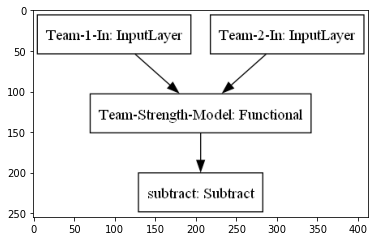

In [11]:
model_summary(model=model, model_name="two_input_seed_diff.png")


We will now use games tournament dataset for training and then use games season dataset for evaluating and comparing with previous model loss

In [12]:
# Get the team_1 column from the regular season data
input_1 = games_tourney["team_1"]

# Get the team_2 column from the regular season data
input_2 = games_tourney["team_2"]

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2], games_tourney["seed_diff"],  epochs=15, batch_size=2048, validation_split=.1, verbose=True)

Epoch 1/15
2/2 [==============================] - 0s 127ms/step - loss: 6.2445 - val_loss: 6.0689
Epoch 2/15
2/2 [==============================] - 0s 14ms/step - loss: 6.2419 - val_loss: 6.0688
Epoch 3/15
2/2 [==============================] - 0s 14ms/step - loss: 6.2394 - val_loss: 6.0687
Epoch 4/15
2/2 [==============================] - 0s 16ms/step - loss: 6.2369 - val_loss: 6.0686
Epoch 5/15
2/2 [==============================] - 0s 14ms/step - loss: 6.2345 - val_loss: 6.0685
Epoch 6/15
2/2 [==============================] - 0s 15ms/step - loss: 6.2320 - val_loss: 6.0684
Epoch 7/15
2/2 [==============================] - 0s 13ms/step - loss: 6.2296 - val_loss: 6.0683
Epoch 8/15
2/2 [==============================] - 0s 13ms/step - loss: 6.2271 - val_loss: 6.0682
Epoch 9/15
2/2 [==============================] - 0s 17ms/step - loss: 6.2247 - val_loss: 6.0681
Epoch 10/15
2/2 [==============================] - 0s 14ms/step - loss: 6.2222 - val_loss: 6.0680
Epoch 11/15
2/2 [===========

In [13]:
# Get the team_1 column from the regular season data
input_1 = games_season["team_1"]

# Get the team_2 column from the regular season data
input_2 = games_season["team_2"]

model.evaluate([input_1, input_2], games_season["seed_diff"])

9756/9756 [==============================] - 8s 861us/step - loss: 1.9173


1.9172719717025757

In [14]:

# Fit the model to input 1 and 2, using score diff as a target
games_season["seed_diff_2"] = model.predict([input_1, input_2]) 
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won,seed_diff,seed_diff_2
0,1985,3745,6664,0,17,81,64,1,-2.664366,-0.060170
1,1985,126,7493,1,7,77,70,1,-1.079953,-0.027199
2,1985,288,3593,1,7,63,56,1,-1.079953,-0.053965
3,1985,1846,9881,1,16,70,54,1,-2.505924,-0.031801
4,1985,2675,10298,1,12,86,74,1,-1.872159,-0.098240


Comparing `seed_diff` and `seed_diff_2` features, we find `seed_diff` more meaningful and we will proceed with `seed_diff` feature for `games_season` dataset in further processes. We will modify the current model and We will now make an input layer for home vs. away after the shared layer. It will now be a 3 input model.


In [15]:
from tensorflow.keras.layers import Input, Concatenate, Dense
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)


# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

We will now train with season data and evaluate with tournament data


In [16]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=15,
          verbose=True,
          validation_split=0.1,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']],
          games_tourney['score_diff'], verbose=False))




Epoch 1/15
138/138 [==============================] - 1s 4ms/step - loss: 12.0901 - val_loss: 12.1866
Epoch 2/15
138/138 [==============================] - 0s 2ms/step - loss: 12.0415 - val_loss: 12.5329
Epoch 3/15
138/138 [==============================] - 0s 1ms/step - loss: 11.9861 - val_loss: 12.9457
Epoch 4/15
138/138 [==============================] - 0s 1ms/step - loss: 11.9289 - val_loss: 13.3951
Epoch 5/15
138/138 [==============================] - 0s 1ms/step - loss: 11.8747 - val_loss: 13.8784
Epoch 6/15
138/138 [==============================] - 0s 1ms/step - loss: 11.8186 - val_loss: 14.4061
Epoch 7/15
138/138 [==============================] - 0s 1ms/step - loss: 11.7652 - val_loss: 14.9366
Epoch 8/15
138/138 [==============================] - 0s 1ms/step - loss: 11.7143 - val_loss: 15.4656
Epoch 9/15
138/138 [==============================] - 0s 1ms/step - loss: 11.6717 - val_loss: 15.9606
Epoch 10/15
138/138 [==============================] - 0s 1ms/step - loss: 11.6335

We will add the model predictions of score difference data as predicted `score_diff` to both dataset so that we can see the comparison.


In [17]:
# Predict
games_tourney['score_diff_pred'] = model.predict([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']])
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won,score_diff_pred
0,1985,288,73,0,-3,-9,41,50,0,0.125736
1,1985,5929,73,0,4,6,61,55,1,0.157117
2,1985,9884,73,0,5,-4,59,63,0,0.003050
3,1985,73,288,0,3,9,50,41,1,0.140986
4,1985,3920,410,0,1,-9,54,63,0,0.285275


In [18]:
# Predict
games_season['score_diff_pred'] = model.predict([games_season['team_1'], games_season['team_2'], games_season['home']])
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won,seed_diff,seed_diff_2,score_diff_pred
0,1985,3745,6664,0,17,81,64,1,-2.664366,-0.060170,0.359935
1,1985,126,7493,1,7,77,70,1,-1.079953,-0.027199,1.975731
2,1985,288,3593,1,7,63,56,1,-1.079953,-0.053965,1.888740
3,1985,1846,9881,1,16,70,54,1,-2.505924,-0.031801,2.097708
4,1985,2675,10298,1,12,86,74,1,-1.872159,-0.098240,2.025476


Previously we have seen that the error is around 11.85 from real values. We will not use `score_diff_pred` as a substitute for `score_diff`. Instead, we will use it as a transformed feature that will help us in next steps. We will create a neural network that will take in this feature and will make the model learn the mapping between `score_diff` and `score_diff_pred`.